In [ ]:
# This code is based on:
# https://gitlab.com/stavros/weii/-/blob/master/weii/cli.py?ref_type=heads

import time
import statistics
import evdev
from evdev import ecodes
from typing import List, Optional


def get_board_device() -> Optional[evdev.InputDevice]:
    """Return the Wii Balance Board device."""
    devices = [
        path
        for path in evdev.list_devices()
        if evdev.InputDevice(path).name == "Nintendo Wii Remote Balance Board"
    ]
    if not devices:
        return None

    board = evdev.InputDevice(
        devices[0],
    )
    return board



def get_raw_measurement(device: evdev.InputDevice) -> float:
    """Read one measurement from the board."""
    data = [None] * 4
    while True:
        event = device.read_one()
        if event is None:
            continue

        # Measurements are in decigrams, so we convert them to kilograms here.
        if event.code == ecodes.ABS_HAT1X:
            # Top left.
            data[0] = event.value / 100
        elif event.code == ecodes.ABS_HAT0X:
            # Top right.
            data[1] = event.value / 100
        elif event.code == ecodes.ABS_HAT0Y:
            # Bottom left.
            data[2] = event.value / 100
        elif event.code == ecodes.ABS_HAT1Y:
            # Bottom right.
            data[3] = event.value / 100
        elif event.code == ecodes.BTN_A:
            sys.exit("ERROR: User pressed board button while measuring, aborting.")
        elif event.code == ecodes.SYN_DROPPED:
            pass
        elif event.code == ecodes.SYN_REPORT and event.value == 3:
            pass
        elif event.code == ecodes.SYN_REPORT and event.value == 0:
            if None in data:
                # This measurement failed to read one of the sensors, try again.
                data = [None] * 4
                continue
            else:
                return sum(data)  # type: ignore

def add_value(list, value, start_time):
    current_time = time.time()
    elapsed_time = round(current_time - start_time, 2)
    list.append((elapsed_time, value))

def measure_weight() -> None:
    """Continuously measure weight from the Wii Balance Board."""
    print("Waiting for balance board...")
    board = None
    while not board:
        board = get_board_device()
        if board:
            break
        time.sleep(0.5)
    print("Balance board found, please step on.")

    try:
        measurements = []
        start_time = time.time()
        while True:
            weight_data = []
            for _ in range(5):  # Collecting samples
                weight_data.append(get_raw_measurement(board))
                time.sleep(0.01)  # Wait between samples

            final_weight = round(statistics.median(weight_data), 2)
            print(f"Weight: {final_weight:.1f} kg")

            add_value(measurements, final_weight, start_time)
            time.sleep(0.1)  # Wait before the next measurement
    except KeyboardInterrupt:
        print("Measurement stopped by user.")
    finally:
        board.close()
        return measurements


measurements = measure_weight()

Waiting for balance board...
Balance board found, please step on.
Weight: 21.8 kg
Weight: 22.7 kg
Weight: 24.8 kg
Weight: 24.2 kg
Weight: 24.2 kg
Weight: 24.3 kg
Weight: 21.4 kg
Weight: 9.0 kg
Weight: 9.2 kg
Weight: 17.7 kg
Weight: 24.1 kg
Weight: 24.2 kg
Weight: 24.2 kg
Weight: 24.2 kg
Weight: 24.3 kg
Weight: 24.3 kg
Weight: 24.2 kg
Weight: 24.2 kg
Weight: 24.2 kg
Weight: 24.3 kg
Weight: 24.3 kg
Weight: 24.2 kg
Weight: 24.3 kg
Weight: 24.2 kg
Weight: 24.3 kg
Weight: 24.3 kg
Weight: 24.2 kg
Weight: 24.3 kg
Weight: 24.3 kg
Weight: 24.3 kg
Weight: 24.2 kg
Weight: 24.2 kg
Weight: 24.3 kg
Weight: 24.2 kg
Weight: 24.2 kg
Weight: 24.2 kg
Weight: 24.3 kg
Weight: 24.2 kg
Weight: 24.3 kg
Weight: 24.3 kg
Weight: 24.2 kg
Weight: 24.3 kg
Weight: 24.3 kg
Weight: 24.2 kg
Weight: 24.3 kg
Weight: 24.2 kg
Weight: 24.3 kg
Weight: 24.2 kg
Weight: 24.3 kg
Weight: 24.3 kg
Weight: 24.3 kg
Weight: 24.3 kg
Weight: 24.2 kg
Weight: 24.3 kg
Weight: 24.2 kg
Weight: 24.3 kg
Weight: 24.3 kg
Weight: 24.2 kg
Weight: 

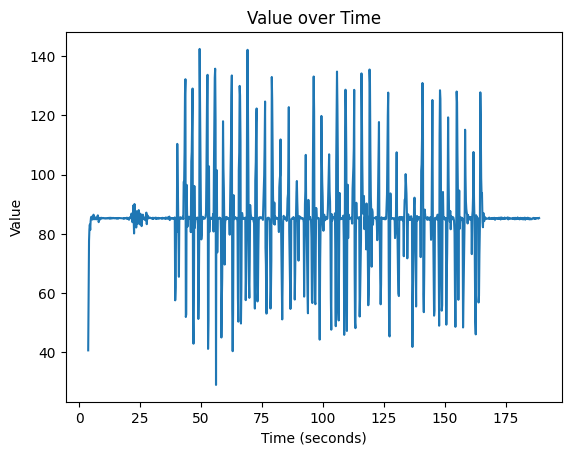

In [9]:
import time
import matplotlib.pyplot as plt

# Separate the times and values for plotting
x = [item[0] for item in measurements]
y = [item[1] for item in measurements]

# Plot the data
plt.plot(x, y)
plt.xlabel('Time (seconds)')
plt.ylabel('Value')
plt.title('Value over Time')
plt.show()

In [10]:
import csv

with open('my_values_fast.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['Time (seconds)', 'Value'])  # Write header
    csvwriter.writerows(measurements)